In [2]:
from pandas_datareader import data

In [1]:
pip install pandas_datareader

     |████████████████████████████████| 109 kB 4.1 MB/s            
You should consider upgrading via the '/opt/homebrew/Caskroom/miniforge/base/envs/tf/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
tickers=["^GSPC"]
start_date="1991-12-31"
end_date="2022-01-01"

panel_data= data.DataReader("^GSPC", "yahoo", start_date, end_date)

In [4]:
snp = panel_data.reset_index()[["Date", "Adj Close"]]

In [5]:
import numpy as np
snp["logPX"] = np.log(snp["Adj Close"])

In [6]:
snp["log_rtn"] = snp["logPX"].pct_change()

In [7]:
import matplotlib.pyplot as plt

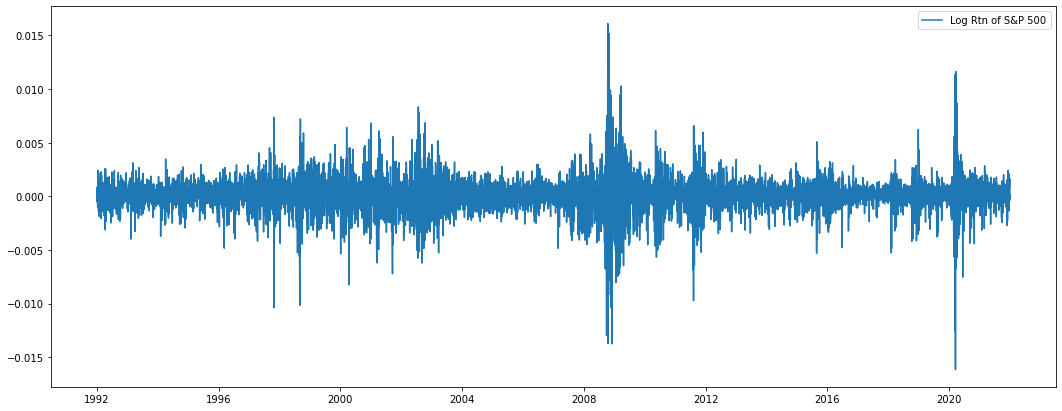

In [10]:
plt.figure(figsize=(18, 7))
plt.plot(snp["Date"], snp["log_rtn"], label="Log Rtn of S&P 500")
plt.legend()
plt.show()

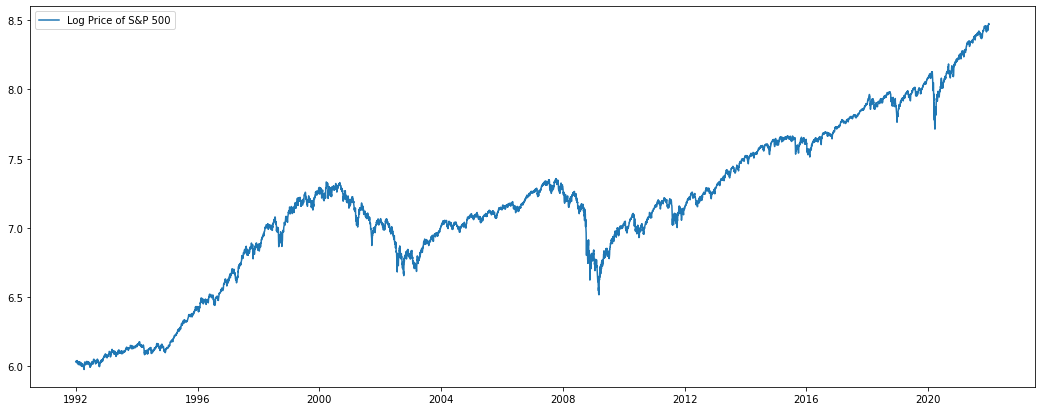

In [11]:
plt.figure(figsize=(18, 7))
plt.plot(snp["Date"], snp["logPX"], label="Log Price of S&P 500")
plt.legend()
plt.show()

In [28]:
import pandas as pd
vol = pd.read_csv(r'/Users/kchoi/repos/MathForDS_JumpModel/data/oxfordmanrealizedvolatilityindices.csv', header=0)

In [29]:
vol.columns

Index(['Unnamed: 0', 'Symbol', 'rsv_ss', 'rk_th2', 'rv5_ss', 'close_price',
       'rk_twoscale', 'nobs', 'bv', 'open_to_close', 'open_price', 'rv10',
       'open_time', 'bv_ss', 'rsv', 'close_time', 'medrv', 'rv5', 'rk_parzen',
       'rv10_ss'],
      dtype='object')

In [30]:
snpVol = vol.query("""Symbol=='.SPX'""")[["Unnamed: 0", "rv5_ss"]]

In [31]:
snpVol.columns=["DATE", "RV5"]

In [32]:
snpVol.DATE = pd.to_datetime(snpVol.DATE.apply(lambda x : str(x)[:10]))

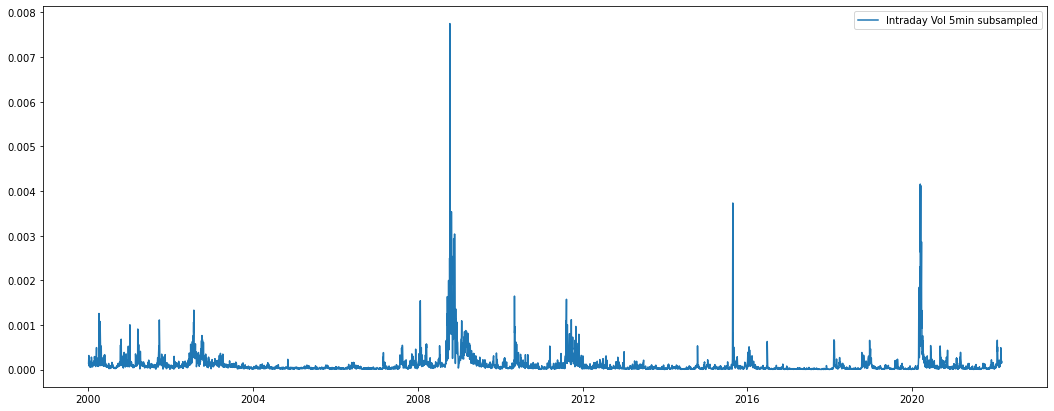

In [35]:
plt.figure(figsize=(18, 7))
plt.plot(snpVol.DATE, snpVol.RV5, label="Intraday Vol 5min subsampled")
plt.legend()

In [36]:
snpVol.DATE

132009   2000-01-03
132010   2000-01-04
132011   2000-01-05
132012   2000-01-06
132013   2000-01-07
            ...    
137561   2022-02-28
137562   2022-03-01
137563   2022-03-02
137564   2022-03-03
137565   2022-03-04
Name: DATE, Length: 5557, dtype: datetime64[ns]

In [37]:
snp.Date

0      1991-12-31
1      1992-01-02
2      1992-01-03
3      1992-01-06
4      1992-01-07
          ...    
7554   2021-12-27
7555   2021-12-28
7556   2021-12-29
7557   2021-12-30
7558   2021-12-31
Name: Date, Length: 7559, dtype: datetime64[ns]

In [38]:
dates = sorted(list(set(pd.to_datetime(snp.Date)).intersection(set(snpVol.DATE))))

In [40]:
snp = snp[snp.Date.isin(dates)]
snpVol = snpVol[snpVol.DATE.isin(dates)]

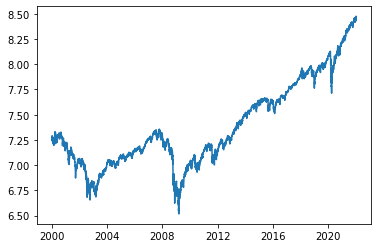

In [41]:
plt.plot(snp.Date, snp.logPX)

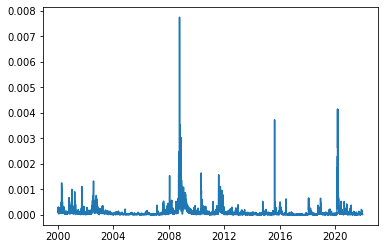

In [42]:
plt.plot(snpVol.DATE, snpVol.RV5)

### HMM Learn

In [44]:
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM

     |████████████████████████████████| 53 kB 2.2 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for hmmlearn: filename=hmmlearn-0.2.7-cp38-cp38-macosx_10_9_x86_64.whl size=97132 sha256=c89d166a19b439b9ebfa12b7c3a73a4ba4c557b0386a26e8b187d9cecdfe3af1
  Stored in directory: /Users/kchoi/Library/Caches/pip/wheels/e8/4b/a1/24635453cf1a631c37223d490ac696cc6d4763b570a606bc38
Successfully built hmmlearn
You should consider upgrading via the '/opt/homebrew/Caskroom/miniforge/base/envs/tf/bin/python3.8 -m pip install --upgrade pip' command.


ImportError: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/hmmlearn/_hmmc.cpython-38-darwin.so, 2): no suitable image found.  Did find:
	/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/hmmlearn/_hmmc.cpython-38-darwin.so: mach-o, but wrong architecture
	/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/hmmlearn/_hmmc.cpython-38-darwin.so: mach-o, but wrong architecture

In [48]:
# from hmmlearn.hmm import GaussianHMM
import hmmlearn

from hmmlearn import hmm

ImportError: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/hmmlearn/_hmmc.cpython-38-darwin.so, 2): no suitable image found.  Did find:
	/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/hmmlearn/_hmmc.cpython-38-darwin.so: mach-o, but wrong architecture
	/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/hmmlearn/_hmmc.cpython-38-darwin.so: mach-o, but wrong architecture

In [216]:
snpVol = snpVol.rename(columns={"DATE" : "Date"})

In [423]:
full_X = snp.merge(snpVol, how="inner", on="Date")

### Features

In [669]:
full_X["abs_log_rtn"] = np.abs(full_X.log_rtn)
full_X["R_mean"] = full_X.log_rtn.rolling(10).mean()
full_X["R_mean_vol"] = full_X.RV5.rolling(10).mean()
full_X["Std_5_rtn"] = full_X.RV5.rolling(5).std()
full_X["Std_10_rtn"] = full_X.RV5.rolling(10).std()
full_X["Abs_10day"] = np.abs(full_X.log_rtn.diff(periods=10))
full_X["Abs_10day_vol"] = np.abs(full_X.log_rtn.diff(periods=10))

In [643]:
full_X

,Date,Adj Close,logPX,log_rtn,RV5,R_mean,Abs_5day,R_mean_vol,Abs_10day,Abs_10day_vol,Std_rtn,Std_5_rtn,Std_10_rtn
0,2000-01-03,1455.219971,7.282912,-0.780679,0.124748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,1399.420044,7.243813,-3.132735,0.445802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,1402.109985,7.245734,0.136744,0.793193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,1403.449951,7.246689,0.059403,0.086194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,1441.469971,7.273419,2.123527,-0.057107,NaN,NaN,NaN,NaN,NaN,NaN,0.341376,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5510,2021-12-27,4791.189941,8.474534,0.925625,-0.348932,0.097663,1.528161,-0.155510,0.289890,0.289890,-0.120503,0.160852,0.184354
5511,2021-12-28,4786.350098,8.473523,-0.086316,-0.301005,0.153719,0.664208,-0.157429,0.560553,0.560553,-0.117800,0.067470,0.185908
5512,2021-12-29,4793.060059,8.474924,0.078842,-0.347536,0.214822,1.033190,-0.168916,0.611034,0.611034,-0.102977,0.019426,0.194427
5513,2021-12-30,4778.729980,8.471930,-0.222142,-0.361087,0.082830,0.833045,-0.205463,1.319923,1.319923,-0.106203,0.023564,0.192573


In [670]:
for col in ["abs_log_rtn", "R_mean", "RV5", "Std_rtn", "Abs_10day", "R_mean_vol", "Abs_10day_vol", "log_rtn"]:
    full_X[col] = (full_X[col] - np.mean(full_X[col])) / np.std(full_X[col])
    

In [671]:
train_X = full_X[full_X["Date"] <= pd.Timestamp("2009-12-31")].dropna()
test_X = full_X[full_X["Date"] > pd.Timestamp("2009-12-31")]

In [672]:
train_dates = train_X.Date
test_dates = test_X.Date

train_data = np.column_stack([train_X.log_rtn, train_X.abs_log_rtn, train_X.R_mean, 
                              train_X.RV5, train_X.Abs_10day, 
                              train_X.R_mean_vol, train_X.Abs_10day_vol,
                              train_X.Std_5_rtn,train_X.Std_10_rtn])
test_data = np.column_stack([test_X.log_rtn, test_X.abs_log_rtn, test_X.R_mean, 
                             test_X.RV5, test_X.Abs_10day, 
                             test_X.R_mean_vol, test_X.Abs_10day_vol,
                             test_X.Std_5_rtn, test_X.Std_10_rtn])

#### HMM 

In [673]:
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(train_data)

In [674]:
hidden_states=model.predict(test_data)

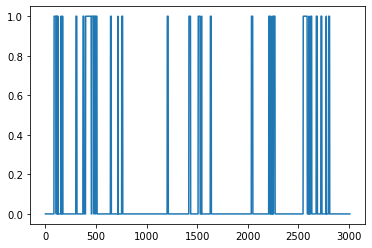

In [675]:
plt.plot(hidden_states)

In [676]:
test_data[400:450]

array([[-4.00045422e+00,  4.39106047e+00, -3.42920727e+00,
         1.27629702e+00,  3.90047570e+00,  2.51916074e-01,
         3.90047570e+00,  4.50237895e-01,  5.19066481e-01],
       [-6.41764412e-02, -7.60152017e-01, -3.47333730e+00,
         3.76750433e+00, -7.53657132e-01,  7.61581297e-01,
        -7.53657132e-01,  1.46523548e+00,  1.20975583e+00],
       [-5.66193727e+00,  6.56536134e+00, -5.37870892e+00,
         3.64774104e+00,  4.01289073e+00,  1.22419746e+00,
         4.01289073e+00,  1.75838379e+00,  1.51052928e+00],
       [ 3.81161500e+00,  4.14393589e+00, -3.85104415e+00,
         5.59626459e+00,  3.04560214e+00,  1.96048903e+00,
         3.04560214e+00,  2.08833439e+00,  2.01646195e+00],
       [-3.72541767e+00,  4.03113370e+00, -4.60498558e+00,
         5.64519092e+00,  1.06413485e+00,  2.65770348e+00,
         1.06413485e+00,  1.79238071e+00,  2.30103207e+00],
       [ 3.72280840e+00,  4.02771908e+00, -3.13548066e+00,
         2.45152578e+00,  2.89665764e+00,  2.993110

#### Jump model

In [685]:
jumped = jump(test_data, 2, jump_penalty=50)

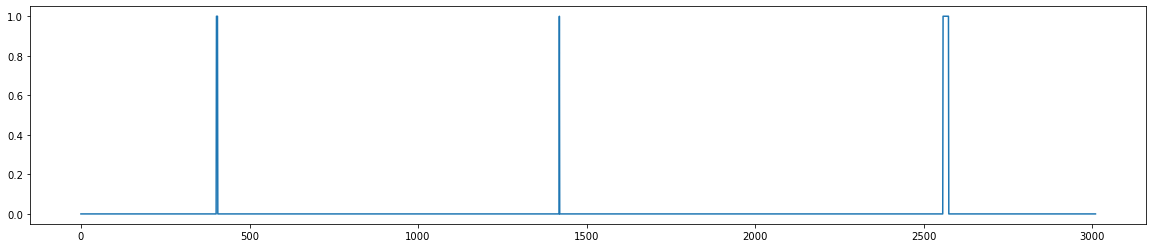

In [686]:
fig = plt.figure(figsize=(20,4))
plt.plot(jumped)

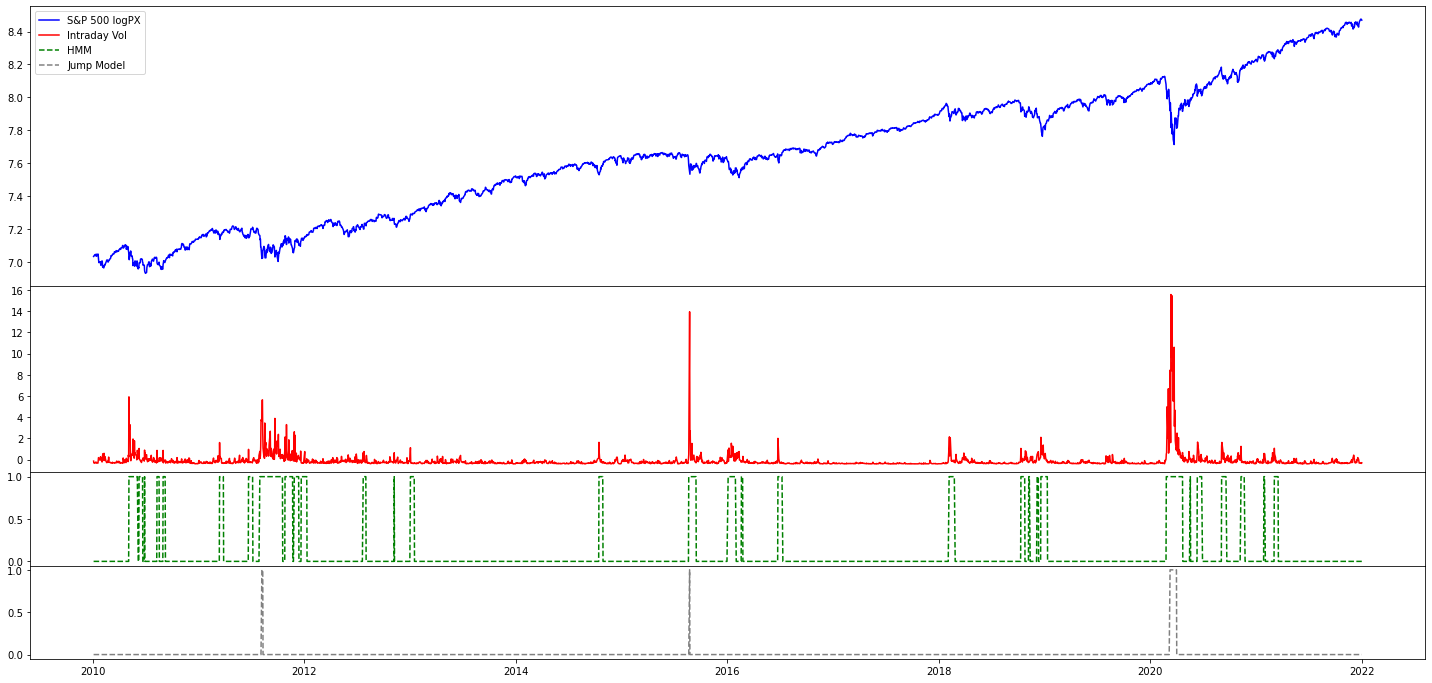

In [687]:
fig = plt.figure(figsize=(25, 12))

gs = gridspec.GridSpec(4,1, height_ratios=[3,2,1,1])
ax0 = plt.subplot(gs[0])
line0, = ax0.plot(test_dates, test_X.logPX, "b")
ax1 = plt.subplot(gs[1], sharex = ax0)
#ax1.set_yscale("log")
line1, = ax1.plot(test_dates, test_X.RV5, "r")
plt.setp(ax0.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[2], sharex = ax0)
line2, = ax2.plot(test_dates, hidden_states, "g", linestyle="--")
plt.setp(ax0.get_xticklabels(), visible=False)

ax3 = plt.subplot(gs[3], sharex = ax0)
line3, = ax3.plot(test_dates, jumped, "grey", linestyle="--")
plt.setp(ax0.get_xticklabels(), visible=False)



yticks=ax1.yaxis.get_major_ticks()
# put legend on first subplot
ax0.legend((line0, line1, line2, line3), ('S&P 500 logPX', 'Intraday Vol', "HMM", "Jump Model"), loc='upper left')
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

### Jump Model Code

In [316]:
import numpy as np
from scipy.spatial.distance import cdist


def sparse_jump(Y, n_states, max_features, jump_penalty=1e-5,
                max_iter=10, tol=1e-4, n_init=10, verbose=False):
    # Implementation of sparse jump model
    n_obs, n_features = Y.shape
    max_features = np.clip(max_features, a_min=1, a_max=np.sqrt(n_features))
    feat_w = np.repeat(1 / np.sqrt(n_features), n_features)
    states = None

    for it in range(max_iter):
        states = jump(Y * np.sqrt(feat_w),
                      n_states,
                      initial_states=states,
                      jump_penalty=jump_penalty,
                      n_init=n_init)
        if len(np.unique(states)) == 1:
            break
        else:
            new_w = get_weights(Y, states, max_features, n_states)
        if abs(new_w - feat_w).sum() / abs(feat_w).sum() < tol:
            break
        elif verbose:
            print('Iteration {}, w diff {:.6e}'.format(it, abs(new_w - feat_w).sum()))
        feat_w = new_w

    return states, feat_w


def jump(Y, n_states, jump_penalty=1e-5, initial_states=None,
         max_iter=10, n_init=10, tol=None, verbose=False):
    # Fit jump model using framework of Bemporad et al. (2018)
    if initial_states is not None:
        initial_states = np.array(initial_states, dtype=np.int64)
        if len(np.unique(initial_states)) == n_states:
            s = initial_states.copy()
        else:
            s = init_states(Y, n_states)
    else:
        s = init_states(Y, n_states)

    n_obs, n_features = Y.shape
    Gamma = jump_penalty * (1 - np.eye(n_states)) 
    best_loss = None
    best_s = None

    for init in range(n_init):
        mu = np.zeros((n_states, n_features))
        loss_old = 1e10
        for it in range(max_iter):
            # Fit model by updating mean of observed states
            for i in np.unique(s):
                mu[i] = np.mean(Y[s==i], axis=0)
            # Fit state sequence
            s_old = s.copy()
            loss_by_state = cdist(mu, Y, 'euclidean').T**2
            V = loss_by_state.copy()
            for t in range(n_obs-1, 0, -1):
                V[t-1] = loss_by_state[t-1] + (V[t] + Gamma).min(axis=1)
            s[0] = V[0].argmin()
            for t in range(1, n_obs):
                s[t] = (Gamma[s[t-1]] + V[t]).argmin()
            # Monitor convergence
            if len(np.unique(s)) == 1:
                break
            loss = min(V[0])
            if verbose:
                print('Iteration {}: {:.6e}'.format(it, loss))
            if tol:
                epsilon = loss_old - loss 
                if epsilon < tol:
                    break
            elif np.array_equal(s, s_old):
                break
            loss_old = loss
            
        if (best_s is None) or (loss_old < best_loss):
            best_loss = loss_old
            best_s = s.copy()
        s = init_states(Y, n_states)

    return best_s


def init_states(Y, n_states):
    # Generate initial states using K-means++ (Arthur and Vassilvitskii, 2007) 
    n_obs, n_features = Y.shape
    centers = np.zeros((n_states, n_features))
    center_idx = np.random.randint(n_obs)
    centers[0] = Y[center_idx]
    n_local_trials = 2 + int(np.log(n_states))
    closest_dist_sq = cdist(centers[0, None], Y, 'euclidean')**2
    current_pot = closest_dist_sq.sum()
    
    for i in range(1, n_states):
        rand_vals = np.random.sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(np.cumsum(closest_dist_sq), 
                                        rand_vals)
        distance_to_candidates = cdist(Y[candidate_ids], Y, 'euclidean')**2
        # Decide which candidate is the best
        best_candidate = None
        best_pot = None
        best_dist_sq = None
        for trial in range(n_local_trials):
            # Compute potential when including center candidate
            new_dist_sq = np.minimum(closest_dist_sq,
                                     distance_to_candidates[trial])
            new_pot = new_dist_sq.sum()

            # Store result if it is the best local trial so far
            if (best_candidate is None) or (new_pot < best_pot):
                best_candidate = candidate_ids[trial]
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        centers[i] = Y[best_candidate]
        current_pot = best_pot
        closest_dist_sq = best_dist_sq
    
    # Compute the state assignment
    states = cdist(centers, Y, 'euclidean').argmin(axis=0)
        
    return states


def get_weights(Y, states, max_features, n_states):
    # Find weights given a state sequence by maximizing the interstate distance
    BCSS = get_BCSS(Y, states)
    delta = binary_search(BCSS, max_features)
    w = calc_new_feature_weights(BCSS, delta)

    return w


def get_BCSS(Y, states):
    # Find BCSS given a state sequence
    WCSS = np.zeros(Y.shape[1])
    for i in np.unique(states):
        mask = (states == i)
        if mask.sum() > 1:
            WCSS += np.square(Y[mask] - np.mean(Y[mask], axis=0)).sum(axis=0)
    TSS = np.square(Y - np.mean(Y, axis=0)).sum(axis=0)

    return TSS - WCSS


def binary_search(objective, norm_constraint, max_iter=15):
    l2n_arg = np.linalg.norm(objective)
    if l2n_arg == 0 or abs(objective / l2n_arg).sum() <= norm_constraint:
        return 0
    lam1 = 0
    lam2 = abs(objective).max() - 1e-5
    for iter in range(max_iter):
        su = soft_threshold(objective, (lam1 + lam2) / 2)
        if abs(su / np.linalg.norm(su)).sum() < norm_constraint:
            lam2 = (lam1 + lam2) / 2
        else:
            lam1 = (lam1 + lam2) / 2
        if (lam2 - lam1) < 1e-4:
            break

    return (lam1 + lam2) / 2


def calc_new_feature_weights(objective, delta):
    # Calculate feature weights using soft thresholding
    soft = soft_threshold(objective, delta)
    w = soft / np.linalg.norm(soft)
    
    return w


def soft_threshold(x, delta):
    
    return np.sign(x) * np.maximum(0, np.abs(x) - delta)
